In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

## Расчёт на прочность КЛА. Вариант 2.3

### Задание 1

Вычислить значения внутренних расчётных усилий по сечениям аппарата для трёх расчётных случаев:
транспортировка, старт, разделение ступеней. Построить эпюры усилий по длине аппарата.

* $m_{2} = 2400 (кг)$

|                 | $n^{э}_{x}$ | $n^{э}_{\delta}$ | $n^{э}_{\delta max}$ | $n^{э}_{\delta min}$ |
|-----------------|:-----------:|:----------------:|:--------------------:|:--------------------:|
| транспортировка | $0$         | $1.5$            |                      |                      |
| старт           | $2.8$       |                  | $2.5$                | $0.7$                |
| разделение      | $5.2$       |                  | $1.0$                | $0.4$                |

In [2]:
class Constants:
    g = 9.81

In [3]:
class Vehicle:
    m2 = 2400
    
    section_count = 13
    block_count = 8
    block_weights = [100, m2, 300, 100, 2000, 300, 1500, 200]
    block_global_size = [6.5, 5.2, 4.3, 3.6, 2.9, 2.1, 1.4, 0.7]

    # Ручные расчёты сечений и координат
    block_in_section = [0, 0, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 7]
    section_local_diameter = [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 2.0909, 2.3455, 2.6, 2.6, 2.6, 2.8, 3.0]
    section_local_size = [0, 0.7, 0.6, 0.6, 0.3, 0.3, 0.4, 0.35, 0.35, 0.8, 0.7, 0.7, 0.7]
    section_global_size = [6.5, 5.8, 5.2, 4.6, 4.3, 4.0, 3.6, 3.25, 2.9, 2.1, 1.4, 0.7, 0]

    def get_global_size(self, section: int) -> float:
        if 0 <= section <= self.section_count:
            return self.section_global_size[section]
        return 0
    
    def get_local_size(self, section: int) -> float:
        return self.section_local_size[section]
    
    def get_local_diameter(self, section: int) -> float:
        return self.section_local_diameter[section]

In [4]:
class Overload:
    def __init__(self, axial=0., lateral=0., lateral_min=0., lateral_max=0., height_list=None, f=1.) -> None:
        self.axial = axial
        self.lateral = lateral
        self.lateral_min = lateral_min
        self.lateral_max = lateral_max
        self.f = f
        self.height_list = height_list

    def set_f(self, f) -> None:
        self.f = f

    def set_height_list(self, height_list=None):
        self.height_list = height_list

    def get_design(self, value) -> float:
        return value * self.f

    def get_design_axial(self) -> float:
        return self.get_design(self.axial)

    def get_design_lateral(self, section=None, height=None) -> float:
        if self.height_list and (height is not None or section is not None):
            if section is not None:
                height = self.height_list[section]
            height1 = self.height_list[0]
            height2 = self.height_list[-1]
            overload1 = self.lateral_max
            overload2 = self.lateral_min
            local_lateral = (height - height1) * (overload2 - overload1) / (height2 - height1) + overload1
            return self.get_design(local_lateral)
        else:
            return self.get_design(self.lateral)

$\frac {x - x_1} {x_2 - x_1} = \frac {y - y_1} {y_2 - y_1}$

In [5]:
transportation = Overload(axial=0, lateral=1.5, f=2)
start = Overload(axial=2.8, lateral_max=2.5, lateral_min=0.7, f=1.3)
separation = Overload(axial=5.2, lateral_max=1.0, lateral_min=0.4, f=1.3)

In [6]:
start.set_height_list(Vehicle.section_global_size)
separation.set_height_list(Vehicle.section_global_size)

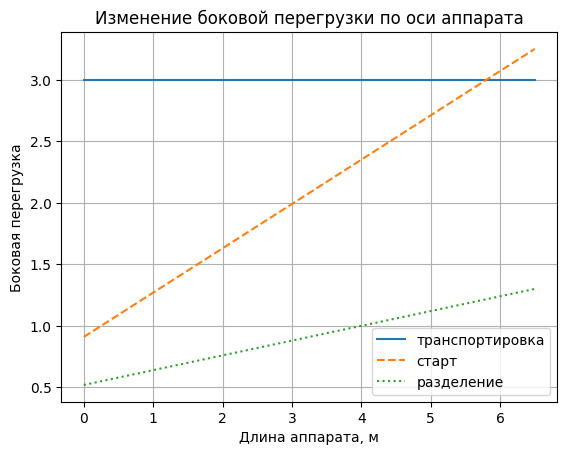

In [7]:
x = np.linspace(0, np.max(Vehicle.section_global_size), 20)

y_trans = [transportation.get_design_lateral(height=i) for i in x]
y_start = [start.get_design_lateral(height=i) for i in x]
y_sep = [separation.get_design_lateral(height=i) for i in x]

plt.title('Изменение боковой перегрузки по оси аппарата')

plt.plot(x, y_trans, '-', label='транспортировка')
plt.plot(x, y_start, '--', label='старт')
plt.plot(x, y_sep, ':', label='разделение')

plt.ylabel('Боковая перегрузка')
plt.xlabel('Длина аппарата, м')

plt.legend()
plt.grid()

In [8]:
print(f'transportation: axial={transportation.get_design_axial():.2f} lateral={transportation.get_design_lateral():.2f}')
print(f'start         : axial={start.get_design_axial():.2f} lateral_min={start.get_design_lateral(12):.2f} lateral_max={start.get_design_lateral(0):.2f}')
print(f'separation    : axial={separation.get_design_axial():.2f} lateral_min={separation.get_design_lateral(12):.2f} lateral_max={separation.get_design_lateral(0):.2f}')

transportation: axial=0.00 lateral=3.00
start         : axial=3.64 lateral_min=0.91 lateral_max=3.25
separation    : axial=6.76 lateral_min=0.52 lateral_max=1.30


In [9]:
def draw_graph(x, y, x_label=None, y_label=None, title=None):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    ax.grid()

In [10]:
P_design_k = lambda m_k, n_design: m_k * Constants.g * n_design
N_design = lambda block_in_section, block_weights, n_design_x: sum([P_design_k(weight, n_design_x) for weight in block_weights[:block_in_section+1]])
Q_design = N_design

In [11]:
class Solver:
    def __init__(self, overload: Overload, vehicle: Vehicle) -> None:
        self.N_design = []
        self.Q_design = []
        self.M_design = []
        self.N_design_eq = []
        self.P_design_axial = []
        self.P_design_lateral = []
        self.overload = overload
        self.vehicle = vehicle
        self.logging = True

    def set_logging(self, logging: bool) -> None:
        self.logging = logging
        
    def run(self) -> None:
        self._clear()
        self._print_title()
        
        for i in range(self.vehicle.section_count):
            block = self.vehicle.block_in_section[i]
            mass_section = self.vehicle.block_weights[block]
            
            current_P_axial = P_design_k(mass_section, self.overload.get_design_axial())
            current_P_lateral = P_design_k(mass_section, self.overload.get_design_lateral(section=i))

            self.P_design_axial.append(current_P_axial)
            self.P_design_lateral.append(current_P_lateral)

            if i == 0:
                self.N_design.append(current_P_axial)
                self.Q_design.append(current_P_lateral)
            else:
                self.N_design.append(self.N_design[-1] + current_P_axial)
                self.Q_design.append(self.Q_design[-1] + current_P_lateral)

            current_M = self.Q_design[-1] * self.vehicle.section_local_size[i]

            if i == 0:
                self.M_design.append(current_M)
            else:
                self.M_design.append(self.M_design[-1] + current_M)

            self.N_design_eq.append(self.N_design[-1] + 4 * self.M_design[-1] / self.vehicle.section_local_diameter[i])

            self._print_last_results(i, block)

                
    def _clear(self) -> None:
        self.N_design.clear()
        self.Q_design.clear()
        self.M_design.clear()
        self.N_design_eq.clear()

    def _print_title(self) -> None:
        if not self.logging:
            return
        print('   | block |    N, N   |    Q, N   |   M, N*m   |   N_eq, N ')
        print('------------------------------------------------------------')

    def _print_last_results(self, row, section) -> None:
        if not self.logging:
            return
        print(f'{row:2}',
            f'  {section}  ',
            f'{self.N_design[-1]:9.2f}',
            f'{self.Q_design[-1]:9.2f}',
            f'{self.M_design[-1]:10.2f}',
            f'{self.N_design_eq[-1]:10.2f}',
            sep=' | ')
    
    def draw_N_design(self) -> None:
        count = len(self.vehicle.section_global_size)
        sections_axis = np.linspace(1, count, count)
        draw_graph(sections_axis, self.N_design, x_label='section', y_label='Н*м', title='N')

    def draw_Q_design(self) -> None:
        count = len(self.vehicle.section_global_size)
        sections_axis = np.linspace(1, count, count)
        draw_graph(sections_axis, self.Q_design, x_label='section', y_label='Н*м', title='Q')

    def draw_M_design(self) -> None:
        count = len(self.vehicle.section_global_size)
        sections_axis = np.linspace(1, count, count)
        draw_graph(sections_axis, self.M_design, x_label='section', y_label='???', title='M')

    def draw_N_design_eq(self) -> None:
        count = len(self.vehicle.section_global_size)
        sections_axis = np.linspace(1, count, count)
        draw_graph(sections_axis, self.N_design_eq, x_label='section', y_label='???', title='N_eq')

    def draw_plots(self) -> None:
        x = np.linspace(1, 13, 13)
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))

        axis[0][0].plot(x, self.N_design)
        axis[0][0].set_title('N')
        axis[0][0].grid()

        axis[0][1].plot(x, self.Q_design)
        axis[0][1].set_title('Q')
        axis[0][1].grid()

        axis[1][0].plot(x, self.M_design)
        axis[1][0].set_title('M')
        axis[1][0].grid()

        axis[1][1].plot(x, self.N_design_eq)
        axis[1][1].set_title('N_eq')
        axis[1][1].grid()


In [12]:
vehicle = Vehicle()

tp_slv = Solver(transportation, vehicle)
st_slv = Solver(start, vehicle)
sep_slv = Solver(separation, vehicle)

In [13]:
tp_slv.run()

   | block |    N, N   |    Q, N   |   M, N*m   |   N_eq, N 
------------------------------------------------------------
 0 |   0   |      0.00 |   2943.00 |       0.00 |       0.00
 1 |   0   |      0.00 |   5886.00 |    4120.20 |    9156.00
 2 |   1   |      0.00 |  76518.00 |   50031.00 |  111180.00
 3 |   1   |      0.00 | 147150.00 |  138321.00 |  307380.00
 4 |   2   |      0.00 | 155979.00 |  185114.70 |  411366.00
 5 |   2   |      0.00 | 164808.00 |  234557.10 |  521238.00
 6 |   3   |      0.00 | 167751.00 |  301657.50 |  577086.42
 7 |   3   |      0.00 | 170694.00 |  361400.40 |  616329.82
 8 |   4   |      0.00 | 229554.00 |  441744.30 |  679606.62
 9 |   5   |      0.00 | 238383.00 |  632450.70 |  973001.08
10 |   6   |      0.00 | 282528.00 |  830220.30 | 1277262.00
11 |   7   |      0.00 | 288414.00 | 1032110.10 | 1474443.00
12 |   7   |      0.00 | 294300.00 | 1238120.10 | 1650826.80


In [14]:
st_slv.run()

   | block |    N, N   |    Q, N   |   M, N*m   |   N_eq, N 
------------------------------------------------------------
 0 |   0   |   3570.84 |   3188.25 |       0.00 |    3570.84
 1 |   0   |   7141.68 |   6129.29 |    4290.50 |   16676.13
 2 |   1   |  92841.84 |  71628.70 |   47267.72 |  197881.22
 3 |   1   | 178542.00 | 132042.60 |  126493.28 |  459638.18
 4 |   2   | 189254.52 | 139276.49 |  168276.23 |  563201.69
 5 |   2   | 199967.04 | 146192.54 |  212133.99 |  671375.91
 6 |   3   | 203537.88 | 148356.63 |  271476.64 |  722886.76
 7 |   3   | 207108.72 | 150397.11 |  324115.63 |  759853.35
 8 |   4   | 278525.52 | 188734.59 |  390172.74 |  878791.27
 9 |   5   | 289238.04 | 193637.63 |  545082.84 | 1127827.02
10 |   6   | 342800.64 | 214444.64 |  695194.09 | 1412330.00
11 |   7   | 349942.32 | 216724.48 |  846901.22 | 1559801.21
12 |   7   | 357084.00 | 218509.90 |  999858.16 | 1690228.21


In [15]:
sep_slv.run()

   | block |    N, N   |    Q, N   |   M, N*m   |   N_eq, N 
------------------------------------------------------------
 0 |   0   |   6631.56 |   1275.30 |       0.00 |    6631.56
 1 |   0   |  13263.12 |   2468.20 |    1727.74 |   17102.54
 2 |   1   | 172420.56 |  29402.53 |   19369.26 |  215463.35
 3 |   1   | 331578.00 |  54641.70 |   52154.28 |  447476.39
 4 |   2   | 351472.68 |  57690.65 |   69461.47 |  505831.50
 5 |   2   | 371367.36 |  60633.65 |   87651.57 |  566148.62
 6 |   3   | 377998.92 |  61567.56 |  112278.59 |  592793.68
 7 |   3   | 384630.48 |  62460.27 |  134139.68 |  613391.40
 8 |   4   | 517261.68 |  79490.43 |  161961.33 |  766432.96
 9 |   5   | 537156.36 |  81762.43 |  227371.28 |  886958.32
10 |   6   | 636629.76 |  91886.35 |  291691.72 | 1085386.25
11 |   7   | 649892.88 |  93071.39 |  356841.69 | 1159666.73
12 |   7   | 663156.00 |  94091.63 |  422705.84 | 1226763.78


In [16]:
sections = [i+1 for i in range(13)]

In [17]:
def draw_summary_plot_by_sections(trans: list, start: list, sep: list,
                                  xscale: int = None, yscale: int = None,
                                  title: str = None,
                                  xlabel: str = None, xdim: str = None,
                                  ylabel: str = None, ydim:str = None
                                  ) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if title:
        ax.set_title(title)

    if yscale:
        ticks = ticker.FuncFormatter(lambda x, pos: f'{x/yscale:g}')
        ax.yaxis.set_major_formatter(ticks)
        if ylabel:
            ylabel += f', {yscale:.1e}'

    ax.plot(sections, trans, '-', label='транспортировка')
    ax.plot(sections, start, '--', label='старт')
    ax.plot(sections, sep, ':', label='разделение')

    if ylabel:
        if ydim:
            if yscale is None:
                ylabel += ','
            ylabel += ' ' + ydim
        ax.set_ylabel(ylabel)

    if xlabel:
        if xdim:
            if xscale is None:
                xlabel += ','
            xlabel += ' ' + xdim
        ax.set_xlabel(xlabel)

    ax.legend()
    ax.grid()

    # return fig

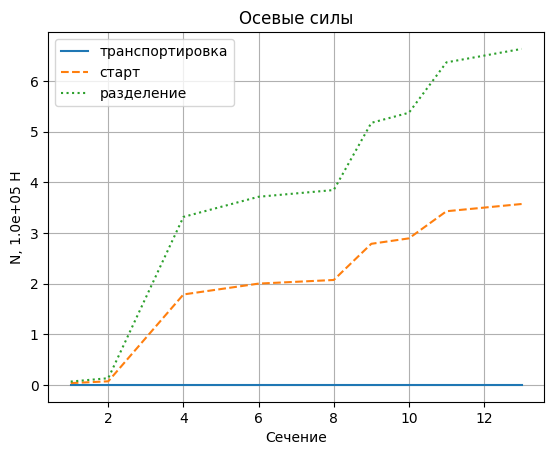

In [18]:
draw_summary_plot_by_sections(tp_slv.N_design, st_slv.N_design, sep_slv.N_design,
                              yscale=1e5, title='Осевые силы',
                              xlabel='Сечение',
                              ylabel='N', ydim='Н')

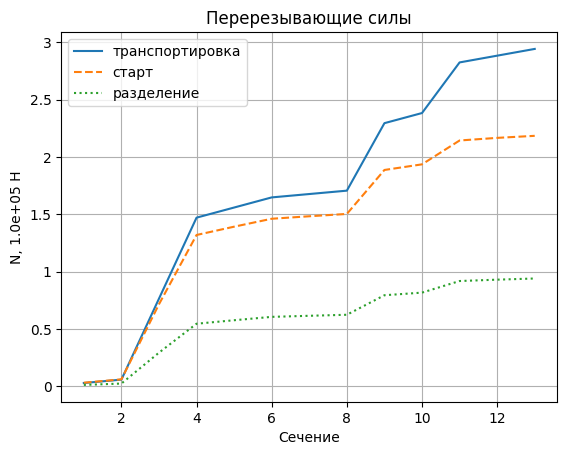

In [19]:
draw_summary_plot_by_sections(tp_slv.Q_design, st_slv.Q_design, sep_slv.Q_design,
                              yscale=1e5, title='Перерезывающие силы',
                              xlabel='Сечение',
                              ylabel='N', ydim='Н')

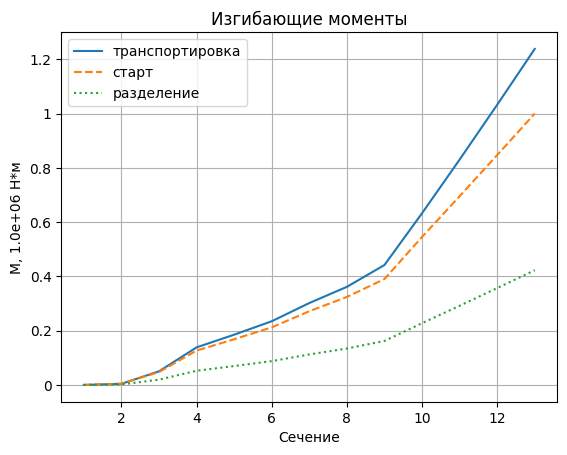

In [20]:
draw_summary_plot_by_sections(tp_slv.M_design, st_slv.M_design, sep_slv.M_design,
                              yscale=1e6, title='Изгибающие моменты',
                              xlabel='Сечение',
                              ylabel='M', ydim='Н*м')

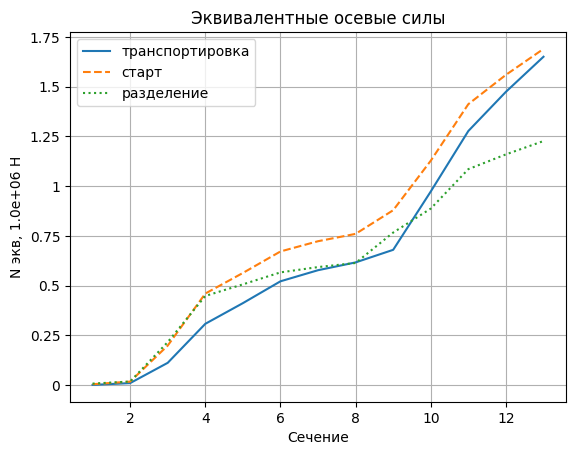

In [21]:
draw_summary_plot_by_sections(tp_slv.N_design_eq, st_slv.N_design_eq, sep_slv.N_design_eq,
                              yscale=1e6, title='Эквивалентные осевые силы',
                              xlabel='Сечение',
                              ylabel='N экв', ydim='Н')

### Задание 2
Выполнить расчёт на прочность приборного отсека 2 от внутреннего давления и усилий по стыку
с цилиндрической проставкой 3, а также цилиндрической проставки 3 от усилий по стыкам.

| $p^{э}, бар$ | $f$     |
|:------------:|:-------:|
| $1.5$        | $1.875$ |

Материал: магниевый сплав МА-2-1

| $\gamma * 10^{-4}, Н/м^3$ | $\sigma_b, МПа$ | $\sigma_{0.2}, МПа$ | $E * 10^{-5}, МПа$ | $\frac {\sigma_b} {\gamma} * 10^{-3}, м$ | $\frac {E} {\gamma} * 10^{-6}, м$ |
|:-------------------------:|:---------------:|:-------------------:|:------------------:|:----------------------------------------:|:---------------------------------:|
| $1.79$                    | $250$           | $140 / 80$          | $0.41$             | $13.9$                                   | $2.3$                             |

In [22]:
p_operational = 1.5 * 10**5	# Pa
f = 1.875

p_design = p_operational * f
p_design

281250.0

In [23]:
class MaterialOrigin:
    gamma = 1.79 * 10**(-4)     # N/m^3
    sigma_b = 250 * 10**6       # Pa
    sigma_02 = 140/80 * 10**6   # Pa
    E = 0.41 * 10**(-5) * 10**6 # Pa
    sigma_b_divide_gamma = 13.9 * 10**(-3) # m !!!! Использую -5 вместо -3
    E_divide_gamma = 2.3 * 10**(-6) # m

In [24]:
class Material:
    gamma = 1.79 * 10**(-4)     # N/m^3
    sigma_b = 250 * 10**6       # Pa
    sigma_02 = 140 * 10**6   # Pa
    E = 0.41 * 10**(5) * 10**6 # Pa
    sigma_b_divide_gamma = 13.9 * 10**(-5) # m !!!! Использую -5 вместо -3
    E_divide_gamma = 2.3 * 10**(-6) # m

In [25]:
Material.sigma_b / Material.gamma * 10**(-3) * 10**(-8)

13.966480446927374

In [26]:
Material.E / Material.gamma * 10**(-14)

2.290502793296089

In [27]:
class Block:
    radius = 0.9        # R
    top_height = 0.4    # b
    spacer_height = 0.6 # H
    shell_height = 1.2  # L

#### Расчёт крышки 1 и донышка 3

Погонные усилия (в эллипсоиде):

* меридиональные: $N_\varphi = \frac {P} {2  b} \sqrt {r^2 (b^2 - a^2) + a^4}$  $[Па * м] [Н / м]$

* окружные: $N_\theta = \frac {P} {2  b} \frac {2 r^2 (b^2 - a^2) + a^4} {\sqrt {r^2 (b^2 - a^2) + a^4}}$  $[Па / м] [Н / м^3]$

Здесь $a$ - большая полуось, $b$ - малая полуось, $r$ - ~~фокусное расстояние~~ радиус (независимая переменная)

Толщина обечайки $\delta_1$ определяется из условия $\frac {N_{\varphi max}} {\delta_1} = \sigma_b$. При наличии сжимающих усилий $N_\theta$ выполняется проверка на устойчивость по формуле $P_{кр} = k \frac {E \delta^2} {a^2 - 2b^2}, k=0.3$. Если условие $p^p \leqslant P_{кр}$ не выполняется, необходимо в зоне сжатия увеличить толщину обечайки.

Построить эпюры $\sigma_\varphi(r) = \frac {N_\varphi} {\delta_1} \pm \frac {6 N_\varphi} {\delta_1^2}$ и $\sigma_\theta(r) = \frac {N_\theta} {\delta_1} \pm \frac {6 N_\theta} {\delta_1^2}$.

In [28]:
LineLoadMeridional = lambda P, r, a, b: P / (2 * b) * np.sqrt(r**2 * (b**2 - a**2) + a**4)	# Pa * m == N / m
LineLoadTangential = lambda P, r, a, b: P / (2 * b) * (2 * r**2 * (b**2 - a**2) + a**4) / np.sqrt(r**2 * (b**2 - a**2) + a**4)	# Pa / m = N / m^3
PCritical = lambda E, delta, a, b: 0.3 * E * delta**2 / (a**2 - 2 * b**2)
SigmaB = lambda line_load, delta: line_load / delta

In [29]:
SigmaPhi = lambda P, r, a, b, depth: LineLoadMeridional(P, r, a, b) / depth + 6 * LineLoadMeridional(P, r, a, b) / depth**2
SigmaTheta = lambda P, r, a, b, depth: LineLoadTangential(P, r, a, b) / depth + 6 * LineLoadTangential(P, r, a, b) / depth**2

In [30]:
semiaxis_a = Block.radius
semiaxis_b = Block.top_height
# focal_distant = semiaxis_a ** 2 - semiaxis_b ** 2
# focal_distant

In [31]:
llm_max = LineLoadMeridional(p_design, 0.9, semiaxis_a, semiaxis_b)
llt_max = LineLoadTangential(p_design, 0.9, semiaxis_a, semiaxis_b)
print(f'llm={llm_max:.2f}\nllt={llt_max:.2f}')

llm=126562.50
llt=-387597.66


In [32]:
llm_min = LineLoadMeridional(p_design, 0, semiaxis_a, semiaxis_b)
llt_min = LineLoadTangential(p_design, 0, semiaxis_a, semiaxis_b)
print(f'llm={llm_min:.2f}\nllt={llt_min:.2f}')

llm=284765.62
llt=284765.62


In [33]:
# llm = LineLoadMeridional(p_design, focal_distant, semiaxis_a, semiaxis_b)
# llt = LineLoadTangential(p_design, focal_distant, semiaxis_a, semiaxis_b)
# print(f'llm={llm:.2f}\nllt={llt:.2f}')

In [34]:
# depth1_0 = llm / Material.sigma_b
# print(f'{depth1_0 * 10**3:5.2f} mm')

In [35]:
depth1_0 = llm_min / Material.sigma_b
print(f'{depth1_0 * 10**3:5.2f} mm')

 1.14 mm


In [36]:
p_critical_0 = PCritical(Material.E, depth1_0, semiaxis_a, semiaxis_b)
print(f'{p_critical_0:.2f}')

32568.98


In [37]:
p_critical_current = p_critical_0
depth1_current = depth1_0
depth_step = 0.1 * 10**(-3)
depths = [depth1_current]
criticals = [p_critical_current]
while p_design > p_critical_current:
	depth1_current += depth_step
	p_critical_current = PCritical(Material.E, depth1_current, semiaxis_a, semiaxis_b)
	depths.append(depth1_current)
	criticals.append(p_critical_current)
depth1 = np.ceil(depth1_current * 10**3) * 10**(-3)
print(f'depth1={depth1}')

depth1=0.004


In [38]:
if len(depths) > 3:
    count = 3
else:
    count = len(depths)

print(f'len(depths)={len(depths)} len(criticals)={len(criticals)}')
for i in range(count):
    print(f'{depths[i] * 10**3:5.2f} mm -> {criticals[i] * 10**(-6):5.3f} MPa')
print('...')
for i in range(count, 0, -1):
    print(f'{depths[-i] * 10**3:5.2f} mm -> {criticals[-i] * 10**(-6):5.3f} MPa')

len(depths)=24 len(criticals)=24
 1.14 mm -> 0.033 MPa
 1.24 mm -> 0.039 MPa
 1.34 mm -> 0.045 MPa
...
 3.24 mm -> 0.263 MPa
 3.34 mm -> 0.280 MPa
 3.44 mm -> 0.297 MPa


In [39]:
PCritical(Material.E, 0.00334, semiaxis_a, semiaxis_b) <= p_design

True

In [40]:
p_critical_1 = PCritical(Material.E, depth1, semiaxis_a, semiaxis_b)
print(f'{p_critical_1:.2f}')

401632.65


Толщина сварного шва: 
$\delta_{св} = \frac {\delta_1} {k_{св}}$

In [41]:
k_sv = 0.8
depth_sv = depth1 / k_sv
print(f'{depth_sv * 10**3:5.2f} mm')

 5.00 mm


In [42]:
x = np.linspace(-Block.radius, Block.radius, 100)

# sigma_b_meridional = []
# sigma_b_tangential = []
# for i in x:
    # sigma_b_meridional.append(SigmaB(LineLoadMeridional(p_design, i, semiaxis_a, semiaxis_b), depth1))
    # sigma_b_tangential.append(SigmaB(LineLoadTangential(p_design, i, semiaxis_a, semiaxis_b), depth1))

In [43]:
sigma_phi = [SigmaPhi(p_design, i, semiaxis_a, semiaxis_b, depth1) for i in x]
sigma_theta = [SigmaTheta(p_design, i, semiaxis_a, semiaxis_b, depth1) for i in x]

In [44]:
def draw_my_plot(x: list, y: list,
                 xscale: int = None, yscale: int = None,
                 title: str = None, label: str = None,
                 xlabel: str = None, xdim: str = None,
                 ylabel: str = None, ydim: str = None,
                 line: str = None
                 ) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if title:
        ax.set_title(title)

    if not line:
        line = '-'

    if xscale:
        ticks = ticker.FuncFormatter(lambda x, pos: f'{x/xscale:.1f}')
        ax.xaxis.set_major_formatter(ticks)
        if xlabel:
            xlabel += f', {xscale:.1e}'
    if yscale:
        ticks = ticker.FuncFormatter(lambda x, pos: f'{x/yscale:.1f}')
        ax.yaxis.set_major_formatter(ticks)
        if ylabel:
            ylabel += f', {yscale:.1e}'

    if ylabel:
        if ydim:
            if yscale is None:
                ylabel += ','
            ylabel += ' ' + ydim
        ax.set_ylabel(ylabel)

    if xlabel:
        if xdim:
            if xscale is None:
                xlabel += ','
            xlabel += ' ' + xdim
        ax.set_xlabel(xlabel)
    
    ax.plot(x, y, line, label=label)

    if label:
        ax.legend()
    ax.grid()

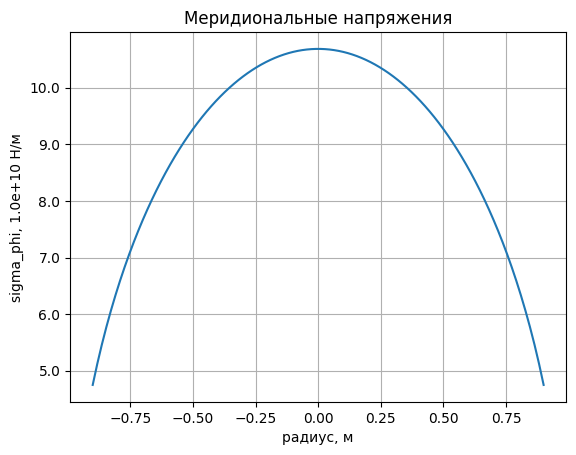

In [45]:
draw_my_plot(x, sigma_phi, title='Меридиональные напряжения', xlabel='радиус', xdim='м', ylabel='sigma_phi', ydim='Н/м', yscale=1e10)

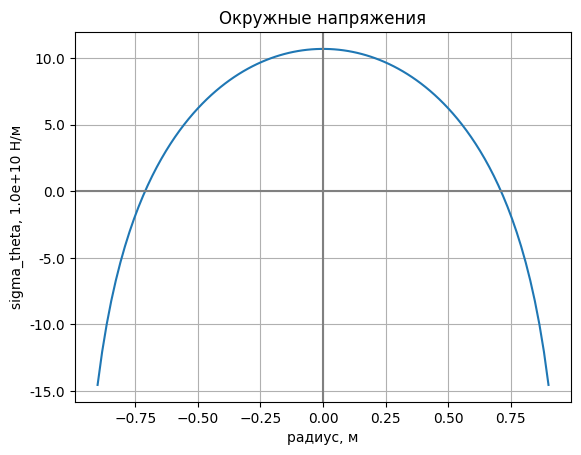

In [46]:
draw_my_plot(x, sigma_theta, title='Окружные напряжения', xlabel='радиус', xdim='м', ylabel='sigma_theta', ydim='Н/м', yscale=1e10)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

In [47]:
# fig, axis = plt.subplots(1, 2, figsize=(15, 4))

# axis[0].set_title('Меридиональные напряжения')
# axis[0].plot(x, sigma_b_meridional)
# axis[0].set_xlabel('радиус, м')
# axis[0].set_ylabel('sigma_phi, Н/м')
# axis[0].axvline(0, color='gray')
# axis[0].grid()

# axis[1].set_title('Окружные напряжения')
# axis[1].plot(x, sigma_b_tangential)
# axis[1].set_xlabel('радиус, м')
# axis[1].set_ylabel('sigma_theta, Н/м')
# axis[1].axhline(0, color='gray')
# axis[1].axvline(0, color='gray')
# axis[1].grid()

#### Расчёт обечайки 2

Из условия обеспечения герметичности толщина обечайки должна быть $\delta_2 \geqslant 2 мм$. Напряжения определяются по формулам:

* $N_{\varphi} = \frac {p R} {2}$
* $N_{\theta} = p R$

Здесь $R$ - радиус цилиндра.

При одновременном действии внешних нагрузок и внутреннего давления коэффициент безопасности для внутреннего давления следует принимать $f = 1$. Тогда минимальные сжимающие напряжения составят
$$\sigma_{x min} = - \frac {N^{p}_{э 1}} {2 \pi R \delta_2} + \frac {p^{э} R} {2 \delta_2}$$

Если $\sigma_{x min} < 0$, то проводится проверка на устойчивость по формуле: $\sigma_{кр} = \frac {k E \delta} {R}$, где $k = \frac {1} {\pi} \sqrt {(\frac {100 \delta} {R})^3}$

In [48]:
N_eq_1 = [tp_slv.N_design_eq[3], st_slv.N_design_eq[3], sep_slv.N_design_eq[3]]

In [49]:
LineLoadMeridional_2 = lambda P, R: P * R / 2
LineLoadTangential_2 = lambda P, R: P * R

In [50]:
llm2 = LineLoadMeridional_2(p_design, Block.radius)
llt2 = LineLoadTangential_2(p_design, Block.radius)

print(f'llm2={llm2 / 10**3:6.2f} * 10^3 N')
print(f'llt2={llt2 / 10**3:6.2f} * 10^3 N')

llm2=126.56 * 10^3 N
llt2=253.12 * 10^3 N


In [51]:
SigmaXMin = lambda N_eq, R, delta2, p_oper: - N_eq / (2 * np.pi * R * delta2) + (p_oper * R) / (2 * delta2) # delta - ?

In [52]:
SigmaCriticalK = lambda delta, R: 1 / np.pi * np.sqrt((100 * delta / R) ** 3)
SigmaCritical = lambda E, delta, R: SigmaCriticalK(delta, R) * E * delta / R

In [53]:
radius_axis = np.linspace(-Block.radius, Block.radius, 100)

llm_2 = []
llt_2 = []

for i in radius_axis:
    llm_2.append(LineLoadMeridional_2(p_design, i))
    llt_2.append(LineLoadTangential_2(p_design, i))

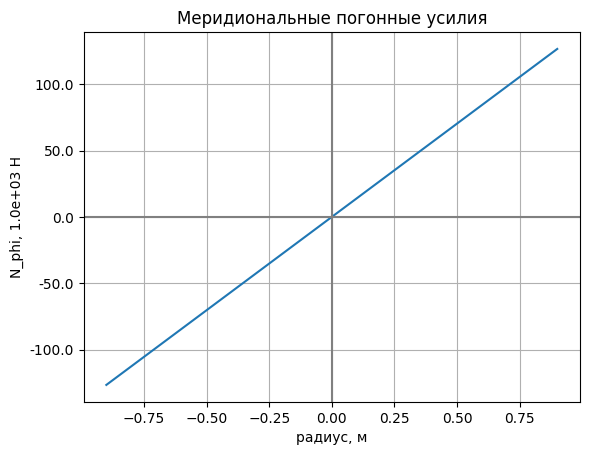

In [54]:
draw_my_plot(radius_axis, llm_2, title='Меридиональные погонные усилия', xlabel='радиус', xdim='м', ylabel='N_phi', ydim='Н', yscale=10**3)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

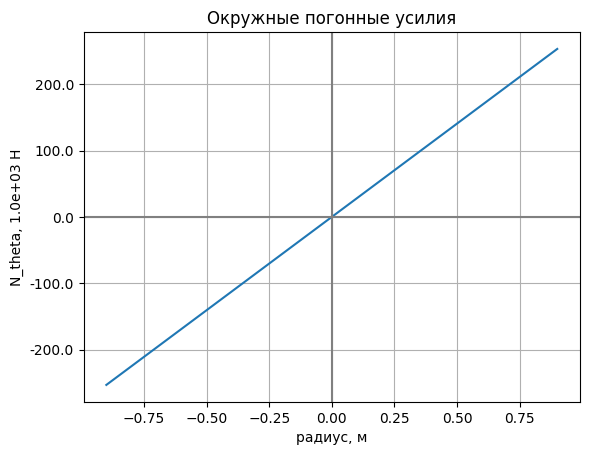

In [55]:
draw_my_plot(radius_axis, llt_2, title='Окружные погонные усилия', xlabel='радиус', xdim='м', ylabel='N_theta', ydim='Н', yscale=10**3)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

In [56]:
# fig, axis = plt.subplots(1, 2, figsize=(15, 4))

# axis[0].set_title('Меридиональные погонные усилия')
# axis[0].plot(radius_axis, llm_2)
# axis[0].set_xlabel('radius')
# axis[0].set_ylabel('N_phi')
# axis[0].axhline(0, color='gray')
# axis[0].axvline(0, color='gray')
# axis[0].grid()

# axis[1].set_title('Окружные погонные усилия')
# axis[1].plot(radius_axis, llt_2)
# axis[1].set_xlabel('radius')
# axis[1].set_ylabel('N_theta')
# axis[1].axhline(0, color='gray')
# axis[1].axvline(0, color='gray')
# axis[1].grid()

In [57]:
depth2 = depth1
depth2

0.004

In [58]:
def print_sigma_x_min(depth: int) -> None:
	print('transportation |  start  | separation')
	print('-------------------------------------')

	sxm_tp = SigmaXMin(N_eq_1[0], Block.radius, depth, p_operational)
	sxm_st = SigmaXMin(N_eq_1[1], Block.radius, depth, p_operational)
	sxm_sep = SigmaXMin(N_eq_1[2], Block.radius, depth, p_operational)

	print(f'{sxm_tp / 10**6:14.2f} | {sxm_st / 10**6:7.2f} | {sxm_sep / 10**6:10.2f}')

In [59]:
min(N_eq_1), N_eq_1

(307380.0, [307380.0, 459638.176, 447476.392])

In [60]:
print_sigma_x_min(depth2)

transportation |  start  | separation
-------------------------------------
          3.29 |   -3.45 |      -2.91


In [61]:
sigma_critical = SigmaCritical(Material.E, depth2, Block.radius)
print(f'sigma critical = {sigma_critical / 10**6:.2f} MPa')

sigma critical = 17.19 MPa


#### Расчёт обечайки проставки 6

Загружение проставки показано на рис. 15. Принимается, что осевые усилия, действующие на кронштейны $N_{кр}$, уравновешиваются равномерным потоком касательных напряжений $q_\tau$.
$$ N_{кр} = \frac {N^p_{э 2}} {4}; q_\tau = \frac {N_{кр}} {2 H} = \frac {N^p_{э 2}} {8 H}$$

В сечении по шпангоуту 5 эквивалентная сила уравновешивается равномерным нормальным потоком: $$q_n = \frac {N^p_{э 2}} {2 \pi R} $$

Нормальные напряжения в обечайке: $$\sigma = \frac {q_n} {\delta_3}$$

Критические нормальные напряжения определяются по формуле (осевое сжатие цилиндрической панели), где $b$ - расстояние (по радиусу):
$$ \sigma_{кр} = \frac {k E \delta} {R} + \frac {3,6 E \delta^2} {b^2}, k = \frac {1} {\pi} \sqrt { \left(\frac {100 \delta} {R} \right)^3} $$

Касательные напряжения: $$\tau = \frac {q_\tau} {\delta}$$

Критические касательные напряжения определяются по формуле (сдвиг цилиндрической панели), где $l$ - высота цилиндра:
$$ \tau_{кр} = 0,78 k \frac {E \delta} {R} \sqrt[4]{\frac {R \delta} {l^2}} + \frac {5,1 E \delta^2} {b^2}, k = 0,6 $$

In [62]:
N_eq_2 = [tp_slv.N_design_eq[5], st_slv.N_design_eq[5], sep_slv.N_design_eq[5]]

In [63]:
LineLoadCritical_6 = lambda N_design_eq: N_design_eq / 4
FlowStressTau_6 = lambda N_design_eq, H: N_design_eq / (8 * H)
FlowStressN_6 = lambda N_degign_eq, R: N_degign_eq / (2 * np.pi * R)

Sigma_6 = lambda q_n, delta: q_n / delta
SigmaCritical_6 = lambda E, delta, R: 1 / np.pi * np.sqrt((100 * delta / R) ** 3) * E * delta / R + 3.6 * E * delta**2 / (2 * np.pi * R)**2

Tau_6 = lambda q_t, delta: q_t / delta
TauCritical_6 = lambda E, delta, R, l: 0.78 * 0.6 * E * delta / R * (R * delta / l**2)**(1/4) + 5.1 * E * delta**2 / (2 * np.pi * R)**2

In [64]:
depth3 = depth2
depth3

0.004

In [65]:
sigma_critical_6 = SigmaCritical_6(Material.E, depth3, Block.radius)
tau_critical_6 = TauCritical_6(Material.E, depth3, Block.radius, Block.shell_height)
print(f'sigma: {sigma_critical_6 / 10**6:.2f} MPa')
print(f'tau  : {tau_critical_6 / 10**6:.2f} MPa')

sigma: 17.26 MPa
tau  : 19.17 MPa


In [66]:
def solver_6(N_design_eq: float) -> tuple:
	llc6 = LineLoadCritical_6(N_design_eq)
	q_tau_6 = FlowStressTau_6(N_design_eq, Block.spacer_height)
	q_n_6 = FlowStressN_6(N_design_eq, Block.radius)
	sigma_6 = Sigma_6(q_n_6, depth3)
	tau_6 = Tau_6(q_tau_6, depth3)
	return llc6, q_tau_6, q_n_6, sigma_6, tau_6

In [67]:
def print_solver_6(llc6, q_tau_6, q_n_6, sigma_6, tau_6) -> None:
    print(f'N kr ={llc6 / 10**3:6.2f} 10^3 N; q t = {q_tau_6 / 10**3:6.2f} 10^3 N/m; q n = {q_n_6 / 10**3:6.2f} 10^3 N/m; sigma = {sigma_6 / 10**6:6.2f} 10^6 Pa; tau = {tau_6 / 10**6:6.2f} 10^6 Pa')

In [68]:
print(f'{"Транспортировка":15}: ', end='')
load_data_tp = solver_6(N_eq_2[0])
print_solver_6(*load_data_tp)

print(f'{"Старт":15}: ', end='')
load_data_st = solver_6(N_eq_2[1])
print_solver_6(*load_data_st)

print(f'{"Разделение":15}: ', end='')
load_data_sep = solver_6(N_eq_2[2])
print_solver_6(*load_data_sep)

Транспортировка: N kr =130.31 10^3 N; q t = 108.59 10^3 N/m; q n =  92.18 10^3 N/m; sigma =  23.04 10^6 Pa; tau =  27.15 10^6 Pa
Старт          : N kr =167.84 10^3 N; q t = 139.87 10^3 N/m; q n = 118.73 10^3 N/m; sigma =  29.68 10^6 Pa; tau =  34.97 10^6 Pa
Разделение     : N kr =141.54 10^3 N; q t = 117.95 10^3 N/m; q n = 100.12 10^3 N/m; sigma =  25.03 10^6 Pa; tau =  29.49 10^6 Pa


#### Расчёт кронштейна 8

Максимальные сжимающие напряжения в кронштейне для исключения потери устойчивости не должны превышать $\sigma_{0.2}$. Тогда потребная площадь поперечного сечения $F = \frac {N_{кр}} {\sigma_{0.2}}$

In [69]:
F_8 = lambda N_critical, sigma_02: N_critical / sigma_02

In [70]:
N_critical_max = np.max([load_data_tp[0], load_data_st[0], load_data_sep[0]])
F = F_8(N_critical_max, Material.sigma_02)
print(f'F = {F:.2e} m^2 = {F * (10**3)**2:.0f} mm^2')

F = 1.20e-03 m^2 = 1199 mm^2


In [71]:
F

0.00119888555

In [72]:
N_critical_max

167843.97699999998

#### Расчёт цилиндрической проставки по уточнённой методике

Необходимо решить задачу о "включении" - передаче сил $N_{кр}$ на обечайку. Принять толщину обечайки $\delta_3 = 2 мм$, площадь кронштейна $\frac {F} {2} = \frac {N_{кр}} {2 \sigma_{0.2}}$